<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Notebook preparation

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
from tdt_autopsy.logregs_extra_experiments import tidy_results
from ipythonme import *
import pandas as pd
import os.path as op
pd.set_option('precision', 2)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 12)
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [3]:
%%javascript
// Avoid scrolling areas to creep in
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Parameter selection and model blending for workflow 2

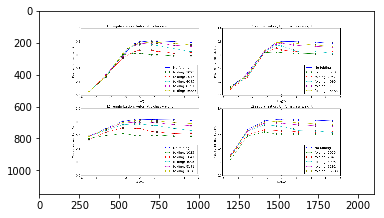

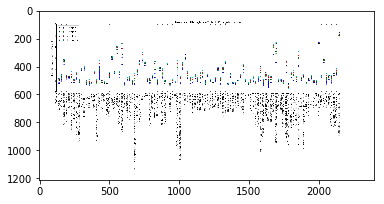

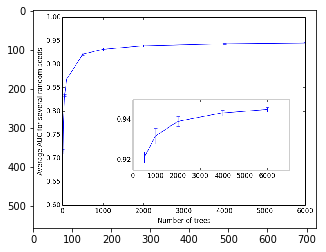

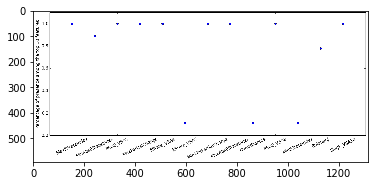

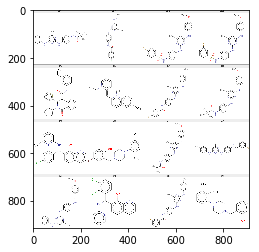

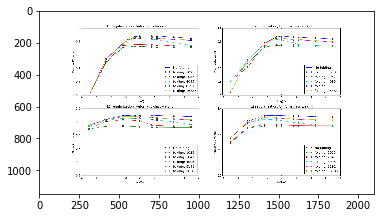

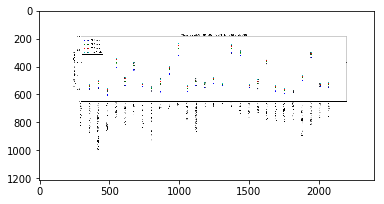

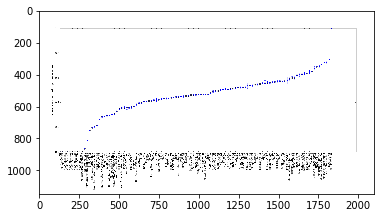

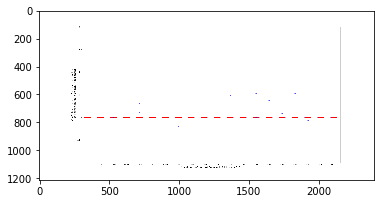

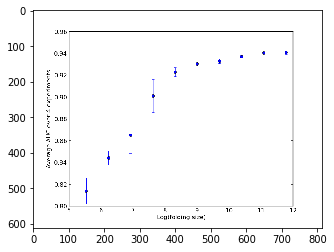

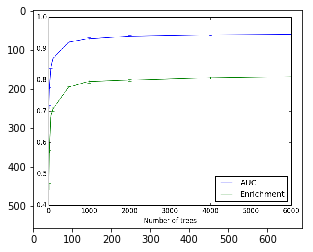

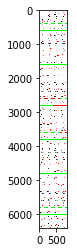

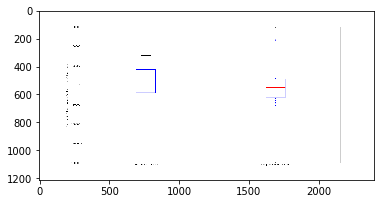

In [4]:
# show_image('./images/workflow2-tutorial/Analysis_task2_auc_fs.png')

images_tutorial_root = './images/workflow2-tutorial/'

images_present = (
    'Analysis_task1_enrichment.png',
    'Analysis_task3_l1.png',
    'AUC_f_numtrees.png',
    'occurrences_features_top10.png',
    'selected_screening.png',
    'Analysis_task1.png',
    'Analysis_task3_l2.png',
    'mean_feat_importances.png',
    'Population_nonfolded_feats_fs=513.png',
    'Analysis_task2_auc_fs.png',
    'AUC_and_enrichment_f_numtrees.png',
    'Mols_having_best_fpt.png',
    'Ranking_differences_in_pb_and_nonpb_foldedbits.png',
)

for image in images_present:
    info(image)
    show_image(op.join(images_tutorial_root, image))


# A discussion of folding stupidities

The hashing trick allows scalable learning on large datasets blah. Hashing happens in two phases: map to an integer (few collisions) and folding (many more collisions).

In [5]:
# Do fingerprint counts follow a Zipf distribution?
# Gradual growth of the feature space

In [6]:
# Let's load the very anecdotical results from the competition benchmark
#   - Train on the whole training set with the best individual logreg
#   - Test in the tiny competition set (1056 mols, around 100 positives)
#     Anecdotical, but gives us the prize and agrees with more serious cross-val + OOB evaluations.
df = tidy_results(recompute=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Data columns (total 33 columns):
data_name                    4064 non-null object
model_name                   4064 non-null object
zero_columns                 4064 non-null object
binarize_threshold           4064 non-null float64
input_is_binary              4064 non-null bool
is_binary                    4064 non-null bool
is_binary_counts             4064 non-null bool
is_regular_counts            4064 non-null bool
unfolded                     4064 non-null bool
fold_as_binary               4064 non-null bool
allow_unseen_in_folding      4064 non-null bool
fold_size                    4064 non-null int64
fold_seed                    4064 non-null object
num_fold_seeds               4064 non-null int64
min_radius                   4064 non-null float64
max_radius                   4064 non-null float64
row_normalizer               4064 non-null object
scale                        4064 non-null bool
auc     

In [7]:
# Note that to keep provenance clear, the dataframe is full of redundancy

COLUMNS = {
    
    # --- Coordinates and IDs
    
    # A hash for this result, based on other coordinats 
    'id',

    # The data id
    # "competition-external" means:
    #   - trained on full TDT labelled dataset 
    #     (with small EC50 based corrections and without ambiguous molecules)
    #   - test is the tiny competition benchmark dataset (1056mols, around 100 positives)
    'data_name',
    
    # human-friendly model ID
    # we selected the two logreg setups we used to deploy our models in the TDT competition
    # (based on grid-search parameter optimization).
    # we actually only carried exercises with L2-regularized models (they work way better
    # and are much faster to train with liblinear)
    'model_name',
    
    # A long whatami like string with the full model configuration
    'model',
    
    # A long whatami like string with the full fingerprint folder configuration
    'folder',
    
    
    # --- Management of empirical feature redundancy
    
    # management of duplicated columns
    # this can be 'none', 'transductive' or 'from_train'
    #
    #  - 'none': no feature has been collapsed to a single representative
    #
    #  - 'from_train': in train features that are equal in the dataset (i.e. appear in
    #    the same molecules, or equivalently, are equal column vectors from the train design matrix)
    #    are made constant zero, therefore deactivating them. One representative of
    #    the group is left.
    #
    #  - 'transductive': as from_train, but we look also at the test dataset (concatenate
    #    train and unlabelled data, check which features from train still are exact duplicates).
    #    note that, obviously, this deactivates less features than using the train matrix only
    #    to assess "equal-in-practice" columns
    'zero_columns',    
    
    
    # --- Binary inputs before folding?
    
    # 0 or inf; counts larger than the threshold are made 1, counts smaller or equal zero
    'binarize_threshold',
    # True or False; a synonym to binarize_threshold == True
    'input_is_binary',
    
    
    # --- Binary inputs after folding?

    # True of False; whether the fingerprints are binarized (0 or 1) or not
    'is_binary',
    # True or False; whether the fingerprints are sum of binary inputs (when folding this makes a difference)
    # Note that even if not binarized, most counts in unfolded fingerprints with large radius are 1
    'is_binary_counts',
    # True or False; whether the fingerprints are regular counts
    'is_regular_counts',
    
    
    # --- Folding
    
    # True or False; True iff the fingerprints have not been folded
    'unfolded',
    # True or False; indicate to fold as binary for binary inputs
    # A synonym for "is_binary and not unfolded"
    'fold_as_binary',
    # True or False
    # When folding, allow features not seen on train to influence the fingerprints of the molecules to test
    # This is common practice in the literature, but can be easily avoided. IF avoided, we 
    # already remove the worst kind of collisions. For example, there are around 50 million features
    # in the commercial set that were not seen in the training set.
    'allow_unseen_in_folding',
    # 511, 1023, 2047, 4091, 8191, 16383, 32767, 4294967295
    # The fold size
    'fold_size',
    # A string like:  
    #   '0', '1', '2', '3', 
    #   '(0, 1)', '(2, 3)', '(4, 5)', '(6, 7)', 
    #   '(0, 1, 2)', '(3, 4, 5)', '(6, 7, 8)', '(9, 10, 11)', 
    #   'nofold'
    # Indicated the seed(s) applied when folding. Multiple seeds indicate multiplefolding
    # (that is, fold several times and summing or and'ing, representing each feature by several
    # columns and so avoiding total colision of different features).
    'fold_seed',
    # 0, 1, 2, 3.
    # The number of seeds using for folding.
    'num_fold_seeds',
    
    
    # --- Radius of the circular fingerprint
    
    # -inf; the minimum radius to use when looking for features
    # it would be somewhat interesting to see the effect of this number
    'min_radius',
    # 2, 3, 4 or inf; the maximum radius to expand to when looking for features
    # these are typical choices in the literature; roughly 2 => ECFP_4, 3 => ECFP_6; 4 => ECFP_8
    # note that, as commented in the original ECFP paper, there is no reason when building models
    # to assume that restricting the radius will help performance by avoiding overfitting. In fact,
    # that will depende how well we manage to combat overfitting by other means.
    'max_radius',
    
    
    # --- Columns and rows normalization
    #
    # We run these experiments on a preliminary version of the data, but have disabled them to
    # prioritize other more interesting aspects. We still keep these preliminary results though,
    # see `tidy_results_01`.
    #
    # Note that anyway most counts are usually small.
    
    # 'none', 'l1', 'l2: 'Normalize row-wise (map row vectors to the unit L1-sphere or unit L2-sphere)
    # In the current version of the data, this is left as None. 
    # Previous experiments showed little point in applying these normalizations for this dataset
    'row_normalizer',
    
    # True of False; apply column-wise scale (keeping sparseness)
    # At the moment, we have only use False here.
    'scale',
    

    # --- Measured performance
    #
    # Note that the benchmark dataset is small, and many of these measurements highly unstable,
    # with large changes depending on random model modes. Specially unstable are early enrichment
    # measurements. We probably want to use enrichment_1 that is the closest to evaluate how
    # we would fare with our very small selection from the commercial compound set.
    #
    # There is an ongoing effort to create a more trustworthy dataset from malaria data in Chembl.
    # Reboot these efforts if this becomes interesting (or just run again a full blown evaluation
    # using regular cross-val on the training set).
    #
    
    'auc',
    'enrichment_1',
    'enrichment_5',
    'enrichment_10',
    'bedroc20',
    'rie20',
    

    # --- Model statistics
    
    # The ratio num_zero_weights / total_num_weights
    # As we are working with L2-regularization, this is 0 most of the time.
    'model_sparsity',


    # --- Times
    
    'pre_column_manipulation_s',
    'fit_s',
    'predict_s',
    'eval_s',
    'total_s',
    
}

In [8]:
show_df(df.query('unfolded and not is_binary_counts').sort_values('auc', ascending=False).head(5))

data_name,model_name,zero_columns,binarize_threshold,input_is_binary,is_binary,is_binary_counts,is_regular_counts,unfolded,fold_as_binary,allow_unseen_in_folding,fold_size,fold_seed,num_fold_seeds,min_radius,max_radius,row_normalizer,scale,auc,enrichment_1,enrichment_5,enrichment_10,bedroc20,rie20,pre_column_manipulation_s,fit_s,predict_s,eval_s,total_s,id,model_sparsity,model,folder
competition-external,tdtl2,from_train,inf,False,False,False,True,True,False,False,4294967295,nofold,0,-inf,inf,none,False,0.84,3.80,5.52,4.34,0.51,4.53,0.02,291.00,4.70e+00,1.35e-02,295.73,3913df9df8492ab4d358036ca1d2962bb4f97157,7.39e-01,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='from_train')),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])",none
competition-external,tdtl2,none,inf,False,False,False,True,True,False,True,4294967295,nofold,0,-inf,inf,none,False,0.84,5.70,5.13,4.44,0.50,4.44,0.03,248.75,1.48e-03,7.14e-03,248.79,52a7044b868f85be77fcc2c692508609e681b96b,1.29e-04,"Pipeline(memory=None,steps=[('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])",none
competition-external,tdtl2,none,inf,False,False,False,True,True,False,False,4294967295,nofold,0,-inf,inf,none,False,0.84,5.70,5.13,4.44,0.50,4.44,0.03,304.31,2.62e-03,1.40e-02,304.36,0872cc9732604eb985c1b2207de1042b75656cce,1.29e-04,"Pipeline(memory=None,steps=[('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])",none
competition-external,tdtl2,transductive,inf,False,False,False,True,True,False,False,4294967295,nofold,0,-inf,inf,none,False,0.84,4.75,5.33,4.14,0.50,4.45,0.03,328.62,3.81e+00,1.32e-02,332.47,6d754b8a867cd633ad4a72d36c45ca969cf114f6,5.17e-01,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='transductive')),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])",none
competition-external,tdtl2,from_train,inf,False,False,False,True,True,False,False,4294967295,nofold,0,-inf,4.00,none,False,0.83,3.80,5.13,4.24,0.49,4.37,39.76,243.57,2.53e+00,6.43e-03,285.87,90c9d2090b872ab179e31e2433f5a9a74a9c79f8,9.27e-01,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='from_train')),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])",none


In [9]:
# We will only look at L2-regularized networks (training with L1 penalty takes much longer to worse results)
df = df.query('model_name == "tdtl2"')
# Also we will remove binarize + fold counts
# These are binarized matrices that become counts on folding
# (each bucket counts the number of substructures going them without taking into account their counts)
# It works well, but I do not think it is common practice, so for the time being I let them out
df = df.query('is_binary or is_regular_counts')

In [10]:
# The table looks like this...
show_df(df.sort_values('auc', ascending=False).head(5))

data_name,model_name,zero_columns,binarize_threshold,input_is_binary,is_binary,is_binary_counts,is_regular_counts,unfolded,fold_as_binary,allow_unseen_in_folding,fold_size,fold_seed,num_fold_seeds,min_radius,max_radius,row_normalizer,scale,auc,enrichment_1,enrichment_5,enrichment_10,bedroc20,rie20,pre_column_manipulation_s,fit_s,predict_s,eval_s,total_s,id,model_sparsity,model,folder
competition-external,tdtl2,transductive,0.00,True,True,False,False,False,True,False,32767,3,1,-inf,inf,none,False,0.85,5.70,5.33,4.54,0.51,4.56,0.03,111.36,1.90,6.76e-03,113.30,f74613662555e8f5aab8d46443fc73bb48f2bbf2,0.0,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='transductive')),('binarize',FastBinarizer(copy=True)),('fold',Folder(as_binary=True,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=True,as_float=False,fold_size=32767,positive=True,seed=3)"
competition-external,tdtl2,transductive,inf,False,False,False,True,False,False,False,32767,3,1,-inf,inf,none,False,0.84,6.65,5.13,4.34,0.50,4.43,0.02,210.16,3.56,1.15e-02,213.76,c00b9701aaa61135d10a771319dc760645d05770,0.0,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='transductive')),('fold',Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)"
competition-external,tdtl2,none,inf,False,False,False,True,False,False,False,32767,3,1,-inf,inf,none,False,0.84,5.70,5.13,4.14,0.50,4.44,0.03,212.98,0.12,9.05e-03,213.14,604ccc2ee76f17c5b6504dbc4d4c2f4ee9c3334f,0.0,"Pipeline(memory=None,steps=[('fold',Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)"
competition-external,tdtl2,transductive,0.00,True,True,False,False,False,True,False,32767,3,1,-inf,4.00,none,False,0.84,5.70,4.14,3.95,0.46,4.13,39.16,111.47,3.26,1.09e-02,153.90,a5b01e79edd36e0d9294c3dea4aeaa5aea5bd69a,0.0,"Pipeline(memory=None,steps=[('zero_columns',ZeroColumns(invert=True,origin='transductive')),('binarize',FastBinarizer(copy=True)),('fold',Folder(as_binary=True,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=True,as_float=False,fold_size=32767,positive=True,seed=3)"
competition-external,tdtl2,none,inf,False,False,False,True,False,False,True,32767,3,1,-inf,4.00,none,False,0.84,5.70,4.34,3.65,0.45,4.04,21.85,102.86,0.08,5.49e-03,124.80,69eb4e9ab1ef47be4bf203ad0db3157fb8a4e1dd,0.0,"Pipeline(memory=None,steps=[('fold',Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)),('model',logreg(C=5,class_weight='balanced',dual=False,fit_intercept=True,intercept_scaling=1,max_iter=100,multi_class='ovr',n_jobs=1,penalty='l2',random_state=0,solver='liblinear',tol=0.0001,verbose=0,warm_start=False))])","Folder(as_binary=False,as_float=False,fold_size=32767,positive=True,seed=3)"


In [11]:
# Lets look at:
# counts vs binary (remember, still not implemented for folding) 
#   => irrelevant for non folding (most values are 1 anyway)
#      result might differ enormously when we allow folding counts
# whether we allow unseen features to add noise in folding
#   => large effect when folding to usual sizes (1024, 2048, 4096)
#      N.B. should we had any small effect of folding seed for no folding, 
#      it would be due to liblinear uncontrollable seed:
#        https://github.com/scikit-learn/scikit-learn/issues/365
#   => the effect is smaller as fold size grows
# how we normalize each row
#   => showed no effect, so to make things more easily graspable, I have moved it to
#      the query from the groupby (look at it back when we add counts to folding)
df.query('not scale and '
         'max_radius > 1000000 and '
         'zero_columns == "none" and '
         'row_normalizer == "none" and '
         'num_fold_seeds < 2').groupby(['fold_size',
                                        'is_binary',
                                        'allow_unseen_in_folding']).auc.describe()

count  mean       std   min  \
fold_size  is_binary allow_unseen_in_folding                                
511        False     False                    4.0    0.71  1.55e-02  0.69   
                     True                     4.0    0.70  2.22e-02  0.67   
           True      False                    4.0    0.69  2.25e-02  0.66   
                     True                     4.0    0.67  3.27e-02  0.63   
1023       False     False                    4.0    0.74  1.70e-02  0.72   
                     True                     4.0    0.73  2.31e-02  0.70   
           True      False                    4.0    0.73  1.89e-02  0.71   
                     True                     4.0    0.71  2.21e-02  0.70   
2047       False     False                    4.0    0.74  1.56e-02  0.72   
                     True                     4.0    0.72  1.28e-02  0.71   
           True      False                    4.0    0.73  1.39e-02  0.71   
                     True                     4.0    0.71  1.70e-02  0.69   
4091       False     False                    4.0    0.78  1.21e-02  0.77   
                     True                     4.0    0.74  1.73e-02  0.72   
           True      False                    4.0    0.77  1.16e-02  0.76   
                     True                     4.0    0.73  1.59e-02  0.71   
8191       False     False                    4.0    0.80  1.84e-02  0.77   
                     True                     4.0    0.78  1.51e-02  0.75   
           True      False                    4.0    0.80  1.83e-02  0.78   
                     True                     4.0    0.78  1.34e-02  0.76   
16383      False     False                    4.0    0.81  1.08e-02  0.80   
                     True                     4.0    0.79  5.84e-03  0.79   
           True      False                    4.0    0.81  1.37e-02  0.80   
                     True                     4.0    0.79  7.70e-03  0.79   
32767      False     False                    4.0    0.82  2.24e-02  0.79   
                     True                     4.0    0.81  2.21e-02  0.79   
           True      False                    4.0    0.82  2.06e-02  0.79   
                     True                     4.0    0.82  2.15e-02  0.79   
4294967295 False     False                    1.0    0.84 NaN        0.84   
                     True                     1.0    0.84 NaN        0.84   
           True      False                    1.0    0.83 NaN        0.83   
                     True                     1.0    0.83 NaN        0.83   

                                               25%   50%   75%   max  
fold_size  is_binary allow_unseen_in_folding                          
511        False     False                    0.70  0.71  0.72  0.72  
                     True                     0.69  0.70  0.71  0.72  
           True      False                    0.68  0.70  0.71  0.71  
                     True                     0.65  0.67  0.69  0.71  
1023       False     False                    0.72  0.73  0.74  0.76  
                     True                     0.71  0.72  0.73  0.76  
           True      False                    0.72  0.72  0.73  0.75  
                     True                     0.70  0.70  0.72  0.74  
2047       False     False                    0.73  0.74  0.75  0.76  
                     True                     0.72  0.73  0.73  0.74  
           True      False                    0.73  0.74  0.74  0.74  
                     True                     0.71  0.72  0.72  0.72  
4091       False     False                    0.77  0.78  0.79  0.80  
                     True                     0.73  0.74  0.75  0.76  
           True      False                    0.76  0.77  0.78  0.78  
                     True                     0.72  0.73  0.74  0.75  
8191       False     False                    0.79  0.80  0.81  0.81  
                     True                     0.77  0.78  0.78  0.79  
       

In [12]:
# Or more focused
df.query('max_radius > 1000000 and '
         'fold_size == 4091 and '
         'zero_columns == "none" and '
         'num_fold_seeds < 2 and '
         'not scale and '
         'row_normalizer == "none"').groupby('allow_unseen_in_folding').auc.mean()


allow_unseen_in_folding
False    0.78
True     0.74
Name: auc, dtype: float64

In [13]:
# What about the max radius?
#  - For small fold sizes, larger radii have no to detrimental effect => Due to growing collision rate?
#  - For large fold sizes and no fold, the model is able to figure out how not to over fit too much => clear gains 
df.query('row_normalizer == "none" and '
         'zero_columns == "none" and '
         'num_fold_seeds < 2 and '
         'not scale').groupby(['fold_size', 
                               'is_binary',
                               'allow_unseen_in_folding',
                               'max_radius']).auc.describe()

count  mean  \
fold_size  is_binary allow_unseen_in_folding max_radius                
511        False     False                   2.00        4.0    0.71   
                                             3.00        4.0    0.72   
                                             4.00        4.0    0.70   
                                             inf         4.0    0.71   
                     True                    2.00        4.0    0.71   
                                             3.00        4.0    0.71   
                                             4.00        4.0    0.69   
                                             inf         4.0    0.70   
           True      False                   2.00        4.0    0.69   
                                             3.00        4.0    0.69   
                                             4.00        4.0    0.69   
                                             inf         4.0    0.69   
                     True                    2.00        4.0    0.69   
                                             3.00        4.0    0.69   
                                             4.00        4.0    0.68   
                                             inf         4.0    0.67   
1023       False     False                   2.00        4.0    0.73   
                                             3.00        4.0    0.75   
                                             4.00        4.0    0.74   
                                             inf         4.0    0.74   
                     True                    2.00        4.0    0.72   
                                             3.00        4.0    0.75   
                                             4.00        4.0    0.73   
                                             inf         4.0    0.73   
           True      False                   2.00        4.0    0.72   
                                             3.00        4.0    0.74   
                                             4.00        4.0    0.72   
                                             inf         4.0    0.73   
                     True                    2.00        4.0    0.71   
                                             3.00        4.0    0.74   
                                             4.00        4.0    0.72   
                                             inf         4.0    0.71   
2047       False     False                   2.00        4.0    0.77   
                                             3.00        4.0    0.75   
                                             4.00        4.0    0.74   
                                             inf         4.0    0.74   
                     True                    2.00        4.0    0.77   
                                             3.00        4.0    0.75   
                                             4.00        4.0    0.74   
                                             inf         4.0    0.72   
           True      False                   2.00        4.0    0.76   
                                             3.00        4.0    0.74   
                                             4.00        4.0    0.73   
                                             inf         4.0    0.73   
                     True                    2.00        4.0    0.76   
                                             3.00        4.0    0.74   
                                             4.00        4.0    0.73   
                                             inf         4.0    0.71   
4091       False     False                   2.00        4.0    0.79   
                                             3.00        4.0    0.79   
                                             4.00        4.0    0.80   
                                             inf         4.0    0.78   
                     True                    2.00        4.0    0.78   
                                             3.00        4.0    0.79   
                         

In [14]:
# Lets look at the effect of zeroing duplicated columns
# No effect when unfolded (which is to be expected)
# There are some effects with other fold sizes
df.query('unfolded').groupby(['fold_size', 'max_radius', 'zero_columns']).auc.describe()

count  mean       std   min   25%   50%  \
fold_size  max_radius zero_columns                                            
4294967295 2.00       from_train    2.0    0.80  2.22e-03  0.79  0.79  0.80   
                      none          4.0    0.80  5.99e-04  0.80  0.80  0.80   
                      transductive  2.0    0.80  7.11e-04  0.80  0.80  0.80   
           3.00       from_train    2.0    0.81  1.47e-03  0.81  0.81  0.81   
                      none          4.0    0.81  1.29e-03  0.81  0.81  0.81   
                      transductive  2.0    0.81  1.66e-03  0.81  0.81  0.81   
           4.00       from_train    2.0    0.83  2.57e-04  0.83  0.83  0.83   
                      none          4.0    0.83  7.78e-04  0.83  0.83  0.83   
                      transductive  2.0    0.83  1.32e-04  0.83  0.83  0.83   
           inf        from_train    2.0    0.84  2.35e-04  0.84  0.84  0.84   
                      none          4.0    0.84  3.35e-04  0.83  0.83  0.84   
                      transductive  2.0    0.84  4.40e-05  0.84  0.84  0.84   

                                     75%   max  
fold_size  max_radius zero_columns              
4294967295 2.00       from_train    0.80  0.80  
                      none          0.80  0.80  
                      transductive  0.80  0.80  
           3.00       from_train    0.81  0.81  
                      none          0.82  0.82  
                      transductive  0.82  0.82  
           4.00       from_train    0.83  0.83  
                      none          0.83  0.83  
                      transductive  0.83  0.83  
           inf        from_train    0.84  0.84  
                      none          0.84  0.84  
                      transductive  0.84  0.84

In [15]:
# What about scaling?
# What about removing duplicates ("representative columns")?
# What about hashing each substructure to different columns?
# What about L1 regularization (note that, as usual, it works worse than L2)?
# What about the same analysis with our original SMARTS feats? (computation needs to be better,
#   - What about completing with other substructures (e.g. our not so clever add FCFP to the mix?).
# What about just using FCFP itself?
# What about RF, now that sklearn supports CSR for building them?
# What about using the malaria dataset I mined out of chembl, so we can trust a bit more the results?
# What about speed differences between folded at different folds and unfolded?
#  - (might be surprising, as sparsity diminishes with smaller folds).

# Revisiting the competition dataset

In [16]:
# Lets read the old results we have access to.
# In particular, we miss workflow1 model used for screening the commercial dataset
# (fingerprints with 4096 buckets, using their original monkey-patching weighting - which was detrimental)
from tdt_autopsy.eval import results_df
rdf = results_df().sort_values('auc', ascending=False).reset_index(drop=True)
# Rename to suit the paper's nomenclature for workflows
rdf.model = rdf.model.str.replace('ccl', 'workflow2').str.replace('sg', 'workflow1')
# Workflow 2 "only use last fold" bug makes no difference
# Let's just keep the intended "average all folds"
rdf = rdf[~rdf.model.str.contains('lastFold')].copy()
# Let's also remove workflow1 modern, as it is roughly the same as moderner
rdf = rdf.query('model != "workflow1_modern"')
rdf

,model,dataset,auc,enrichment_1,enrichment_5,enrichment_10,bedroc20,rie20
1,workflow2_logregs_avg_linr,competition_benchmark,0.83,7.60,4.73,3.55,0.47,4.16
2,workflow2_workflow1_blend,competition_benchmark,0.81,4.75,4.14,3.95,0.42,3.73
3,workflow1_moderner_4096,competition_benchmark,0.80,3.80,3.16,3.65,0.39,3.44
5,workflow1_moderner,competition_benchmark,0.79,4.75,3.95,3.25,0.39,3.48
7,workflow2_final_avg_avg,competition_benchmark,0.79,4.75,4.34,3.95,0.44,3.96
10,workflow2_final_avg_linr,competition_benchmark,0.79,3.80,4.34,3.65,0.42,3.78
11,workflow2_logregs_avg_avg,competition_benchmark,0.78,7.60,4.14,3.65,0.44,3.96
12,workflow2_trees_avg,competition_benchmark,0.76,3.80,4.54,3.55,0.42,3.73
13,workflow2_trees_linr,competition_benchmark,0.75,5.70,4.93,3.45,0.44,3.92
14,workflow1_old,competition_benchmark,0.75,2.85,2.96,2.76,0.32,2.88


In [17]:
# Also from table 3 in the paper
# Method, AUC, EF5%
# Workflow 1 - Fusion model (1024/2048 bits): 0.74, 2.76
# Workflow 1 - Fusion model (4096 bits) 0.75, 4.75
# Workflow 2: 0.79, 4.34

# Remember: enrichment measurements are specially dodgy with such small datasets
# Again, what was the difference between modern and moderner?

# competition-external	tdtl2	none	inf	False	False	False	True	True	False	True	4294967295	nofold	0	-inf	inf	none	False	0.84	5.70	5.13	4.44	0.50	4.44	0.03	248.75	1.48e-03

# Unseen collision stats

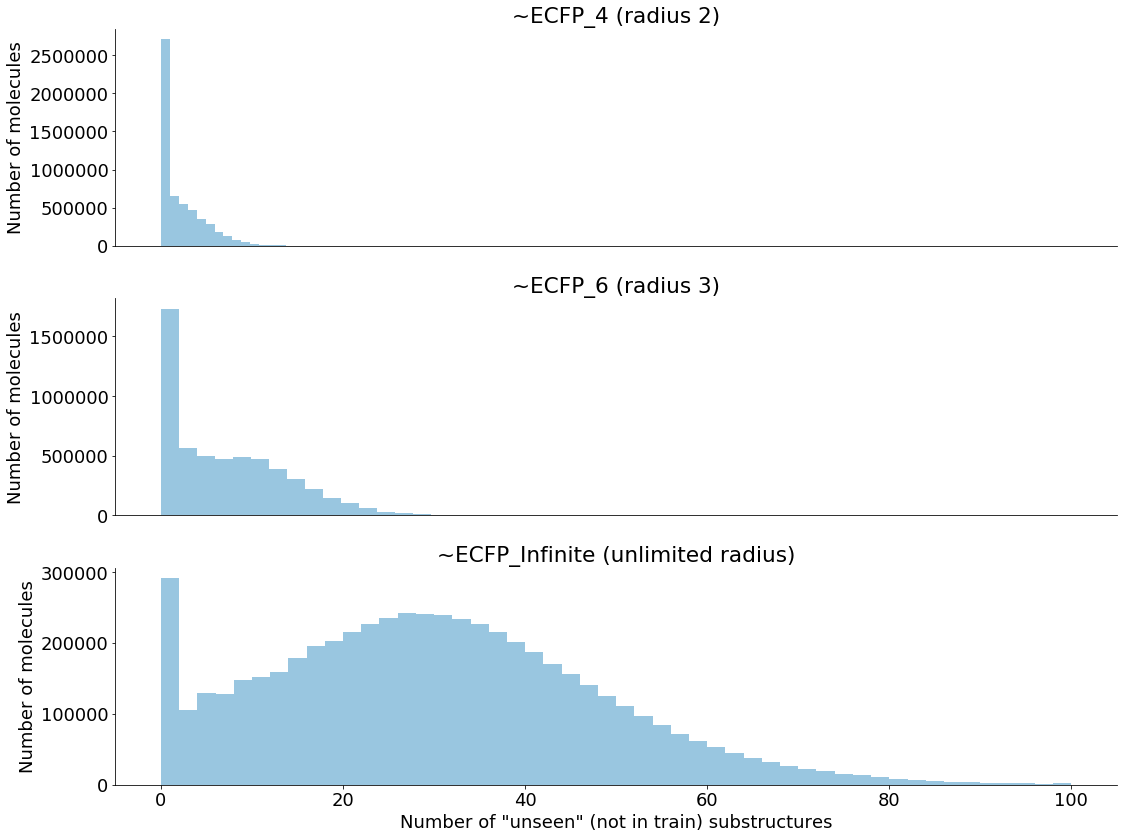

In [18]:
import feather
import os.path as op
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18, 'figure.figsize':(16, 12)})
sns.set_palette(sns.color_palette('colorblind'))

# These are all the results that there are
UNSEEN_COLLISIONS_ROOT = '../../data/--unfolded-explorations/unseen-features-collisions-results'
RADII = [
    ('radius2',  100, '~ECFP_4 (radius 2)'),
    ('radius3', 100, '~ECFP_6 (radius 3)'),
    ('infinite-radius', 100, '~ECFP_Infinite (unlimited radius)'),
]
fig, axes = plt.subplots(ncols=1, nrows=len(RADII), 
                         sharex=True, sharey=False)
for (radius, max_non_train, title), ax in zip(RADII, axes):
    per_feature_df = feather.read_dataframe(op.join(UNSEEN_COLLISIONS_ROOT,
                                                    radius,
                                                    'per_feature_df.feather'))
    per_molecule_df = feather.read_dataframe(op.join(UNSEEN_COLLISIONS_ROOT,
                                                     radius,
                                                     'per_molecule_df.feather'))
    
    ax = sns.distplot((per_molecule_df.
                       query('num_features_not_in_train_per_mol <= %d' % max_non_train)
                       ['num_features_not_in_train_per_mol']),
                       bins=None,
                       norm_hist=False,
                       kde=False, 
                       axlabel='Number of "unseen" (not in train) substructures',
                       ax=ax)
    ax.set_title(title)    
    ax.set_ylabel('Number of molecules')
for ax in axes[:-1]:
    ax.xaxis.set_visible(False)
sns.despine(fig)
plt.tight_layout()
plt.savefig('images/unseen_collisions.png')
plt.savefig('images/unseen_collisions.svg')

In [19]:
# We should also look at average "on" bits and plot a vertical line in there. 
# It must include also features seen in train
#
# Even better, per molecule we could compute the percentage of unseen features it provides
# and plot it.
#
# For the future...